# Shop Location Choice 

Great news! Our shop developes so well that we will open a second one! We already have a few locations in mind, but would like to know which one is the most suitable for us. 

In [1]:
import folium

from openrouteservice import client
import openrouteservice

from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib import pylab
import pandas as pd

## Isochrones

Therefore, we'd like to get some information about the area around each location. We distinguish between foot walking and car driving profile and a range of 5 and 15 minutes.
- foot-walking
- driving-car


- 5 minutes
- 15 minutes

In [2]:
api_key = '58d904a497c67e00015b45fc2a6b6872037d44119582ef40cdf264c4' # Provide your personal API key
clnt = client.Client(key=api_key) # Create client with api key
map_berlin = folium.Map(tiles='Stamen Toner', location=([52.515803, 13.390617]), zoom_start=11) # Set up folium map

# The location options
location_options = [13.353882, 52.570716], [13.311653, 52.518937], [13.327103, 52.489888], [13.378258, 52.50452], [13.446579, 52.489888], [13.440056, 52.536482], [13.382893, 52.540188]

foot_iso = []
foot_pop = []
car_iso = []
car_pop = []

for loc in location_options:
    
    # foot profile
    iso_params = {'locations': loc,
                  'profile': 'foot-walking',
                  'range_type': 'time',
                  'intervals': [300, 900], # 5 and 15 minutes
                  'attributes': {'total_pop', 'area', 'reachfactor'}
                 }
    iso_foot_request = clnt.isochrones(**iso_params)
    foot_iso.append(iso_foot_request)
    folium.Marker(list(reversed(loc)),popup='Store Option {}'.format(location_options.index(loc)+1)).add_to(map_berlin)
    
    for feature in iso_foot_request['features']:
        coords = [(y,x) for x,y in feature['geometry']['coordinates'][0]]
        folium.features.PolygonMarker(coords,
                                         color='#ffd699',
                                         fill_color='#ffd699',
                                        fill_opacity=0.2,
                                         weight=3).add_to(map_berlin)
        
        foot_pop += [feature['properties']['total_pop']] # Receive total population of each region
        
    
    # car profile
    del iso_params['profile']
    iso_params['profile'] = 'driving-car' # Change profile from foot-walking to driving-car
    
    # It is also possible to use the segments parameter instead of intervals
    del iso_params['intervals']
    iso_params['segments'] = 300 # 5 minutes
    
    iso_car_request = clnt.isochrones(**iso_params) # Request for car profile with a time range of 300 seconds or 5 minutes
    folium.GeoJson(iso_car_request).add_to(map_berlin)
    car_iso.append(iso_car_request)
    
    for feature in iso_car_request['features']:
        car_pop += [feature['properties']['total_pop']] # Receive total population of each region
    
map_berlin

We can get some general information of each region:

Row ID,Location,Total Area,Total Population,Reach Factor
0,1,20.6813,119780,0.1302
1,2,13.2255,87296,0.0835
2,3,27.3576,180935,0.1730
3,4,22.5186,145832,0.1430
4,5,16.7720,98386,0.1067
5,6,15.8574,105213,0.1018
6,7,10.9875,74856,0.0697


<BarContainer object of 7 artists>

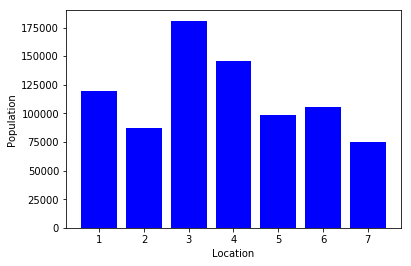

In [3]:
# Where can I reach the most people in 5 minute car drive?
data = []
pop_values = []
for iso in car_iso:
    index = car_iso.index(iso)+1
    area = iso['features'][0]['properties']['total_area_km']
    pop = iso['features'][0]['properties']['total_pop']
    reach = iso['features'][0]['properties']['reachfactor']
    data += [[index, area, pop, reach]]
    pop_values.append(pop)

df = pd.DataFrame(data=data, columns = ['Location','Total Area','Total Population','Reach Factor'])
df.columns.name = 'Row ID'
display(df)

# population plot    
y = pop_values
N = (len(y)+1)
x = range(1,N)
pylab.xlabel('Location')
pylab.ylabel('Population')
plt.bar(x, y, color="blue")

Okay the third location looks quite good, but we would like to have a closer look as well at the foot walking area.

In [5]:
def style_function(color):
    return lambda feature: dict(color=color)

# Highest population density in 15 minute foot catchment 
for iso in foot_iso:
    for loc in iso['features']: 
        if loc['properties']['total_pop'] == max(foot_pop):
            print('There is a total population of {} and a reachfactor of {} in the chosen area.'.format(iso['features'][0]['properties']['total_pop'], iso['features'][0]['properties']['reachfactor']))
            folium.GeoJson(iso, style_function=style_function('red')).add_to(map_berlin)
        
map_berlin

There is a total population of 5140 and a reachfactor of 0.9059 in the chosen area.


That is not too bad! But we don't want to decide too fast. Let's have also a look at the fourth location, with the second highest population density and our three suppliers.

In [8]:
loc_choise = [car_iso[2], car_iso[3]] # The two locations with the highest population values in 5 minute car drive 

# Cleaning up map
cleaned_map = folium.Map(tiles='Stamen Toner', location=([52.489888, 13.327103]), zoom_start=11) # Set up folium map
for loc in loc_choise:
    folium.GeoJson(loc).add_to(cleaned_map)
    folium.Marker(list(reversed(loc['features'][0]['properties']['center'])), popup='Shop Option {}'.format(loc_choise.index(loc)+1)).add_to(cleaned_map)

    
# Suppliers
supplier_list = [[13.178101, 52.551724], [13.445892, 52.422523], [13.567429, 52.566752]]

for sup in supplier_list:
    folium.Marker(list(reversed(sup)), popup='Supplier').add_to(cleaned_map)
    
cleaned_map

Now we want to check how much time our suppliers would need to each location. Therefore, we are using the Matrix API.

## Distance Matrix

In [9]:
# Delivery time for suppliers
for loc in loc_choise:
    supplier_list.append(loc['features'][0]['properties']['center'])
    
matrix_request = []
matrix_params = {'locations': supplier_list,
                'profile': 'driving-hgv',
                'resolve_locations':'true',
                'sources': [3,4] # shop locations
                }
matrix_request.append(clnt.distance_matrix(**matrix_params))
    
counter = 0
print('Delivery time for the suppliers: \n ')
for dura in matrix_request[0]['durations']:
    counter += 1
    print('  To the {} location: {:.2f} minutes'.format(counter, sum(dura[0:3])/60))

Delivery time for the suppliers: 
 
  To the 1 location: 67.02 minutes
  To the 2 location: 62.27 minutes


It takes a bit longer to the first location, but the five minutes are okay compared to the other benefits.